# Chinook Database 

The Chinook database schema is:
![Image](https://www.basedonstatistics.com/wp-content/uploads/2018/06/chnk.png :"schema")


## Importing Modules and Creating Helper Functions
Importing SQLite, pandads, and matplotlib modules

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


creating a `run_query()` function that takes a SQL query as an argument and returns a pandas dataframe of that query

In [2]:
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)

creating a `run_command()` function that takes a SQL command as an argument and executes it using the sqlite module. 

In [3]:
def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)

creating a `show_tables()` function that calls the `run_query()` function to return a list of all tables and views in the database.

In [4]:
def show_tables():
    q= '''
        SELECT
            name, 
            type
        FROM sqlite_master
        WHERE type IN ('table', 'view');
        '''
    return run_query(q)

The views and tables that exist in the database are:

In [5]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


The Chinook record store has just signed a deal with a new record label, and we've been tasked with selecting the first three albums that will be added to the store, from a list of four. All four albums are by artists that don't have any tracks in the store right now. We have the artist names, and the genre of music they produce:

| Artist Name | Genre |
| --- | --- |
| Regal | Hip-Hop |
| Red Tone | Punk |
| Meteor and the Girls |  Pop |
|Slim Jim Bites | Blues |

The record label specializes in artists from the USA, and they have given Chinook some money to advertise the new albums in the USA, so we're interested in finding out which genres sell the best in the USA.

We'll write a query to find out which genres sell the most tracks in the USA, and then create a visualization of that data using pandas.

## Determining Which Albums to Purchase


In [6]:
usa_genre_stats = '''
    WITH tracks_purchased_from_usa AS (
        SELECT il.* FROM invoice_line il
        INNER JOIN invoice i ON i.invoice_id = il.invoice_id
        INNER JOIN customer c ON c.customer_id = i.customer_id
        WHERE c.country = "USA" )
    
    SELECT
        g.name genre,
        COUNT(tpusa.invoice_line_id) tracks_sold,
        CAST(COUNT(tpusa.invoice_line_id) AS FLOAT)/(SELECT COUNT(*) FROM tracks_purchased_from_usa)*100 percentage_sold
    FROM tracks_purchased_from_usa tpusa
    INNER JOIN track t ON t.track_id = tpusa.track_id
    INNER JOIN genre g ON g.genre_id = t.genre_id
    GROUP BY 1
    ORDER BY 2 DESC
    LIMIT 15
    '''
run_query(usa_genre_stats)

,genre,tracks_sold,percentage_sold
0,Rock,561,53.377735
1,Alternative & Punk,130,12.369172
2,Metal,124,11.798287
3,R&B/Soul,53,5.042816
4,Blues,36,3.425309
5,Alternative,35,3.330162
6,Latin,22,2.093245
7,Pop,22,2.093245
8,Hip Hop/Rap,20,1.902950
9,Jazz,14,1.332065


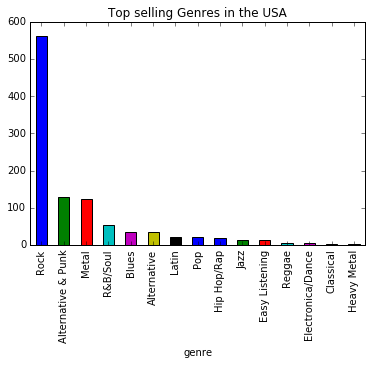

In [7]:
usa_track_stats = run_query(usa_genre_stats)
usa_track_stats.set_index('genre', inplace = True, drop = True)

usa_track_stats['tracks_sold'].plot.bar (title = "Top selling Genres in the USA")
plt.show()


The above plot shows the amount of tracks sold in the USA from greatest to least by genre. Given the genres for the albums that we can chose from are Hip-Hop, Punk, Pop, and Blues, Hip-Hop is the least popular(though, by a small margin) of these choices accounting for approximately 2% of sales. 
Chosing the Punk, Pop, and Blues genres will account for approximately 18% of sales combined. 

| Artist Name | Genre | Percentage of USA Sales
| --- | --- |---
| Red Tone | Punk | 12.37
|Slim Jim Bites | Blues | 3.43
| Meteor and the Girls |  Pop | 2.10



## Sales per Employee

Each customer for the Chinook store gets assigned to a sales support agent within the company when they first make a purchase. We can analyze the purchases of customers belonging to each employee to see if any sales support agent is performing either better or worse than the others.


In [8]:
sales_rep_totals = '''
    SELECT 
        e.first_name || " " || e.last_name employee_name,
        e.hire_date date_hired,
        e.reports_to supervisor,
        SUM(i.total) sales_total
    FROM employee e
    INNER JOIN customer c ON c.support_rep_id = e.employee_id
    INNER JOIN invoice i ON i.customer_ID = c.customer_id
    WHERE title = "Sales Support Agent"
    GROUP BY employee_name
    ORDER BY date_hired'''

run_query (sales_rep_totals)

,employee_name,date_hired,supervisor,sales_total
0,Jane Peacock,2017-04-01 00:00:00,2,1731.51
1,Margaret Park,2017-05-03 00:00:00,2,1584.00
2,Steve Johnson,2017-10-17 00:00:00,2,1393.92


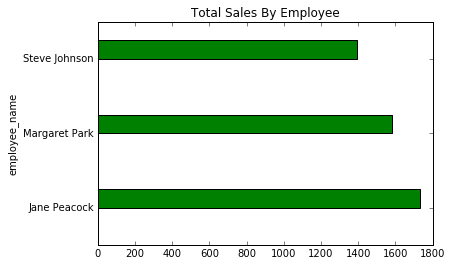

In [9]:
sales_per_rep = run_query(sales_rep_totals)

sales_per_rep.set_index('employee_name', inplace = True, drop = True)

sales_per_rep.plot.barh(title = "Total Sales By Employee", legend = False)
plt.show()


Total amount of sales appears to correlate with length of time in the Sales Support Agent role. There is only a %20 percent difference between the top and bottom performers.

## Sales Data By Country
Next we will analyze the sales data for customers from each different country using the country value from the customers table.
We will examine:

- total number of customers
- total value of sales
- average value of sales per customer
- average order value

For countries with only 1 customer, the data will be aggregated into a group named "Other"

In [10]:
## first creating a table with the country column to include 'Other' in the case of only 1 customer
# then selecting our analytics
# the sort column allows the "Other" grouping to be sorted to the bottom of our table

customer_country_sales = '''
WITH customer_country_data AS (
        SELECT
            CASE
                WHEN (SELECT count(*)
                    FROM customer
                    WHERE country = c.country
                    ) = 1 THEN "Other"
               ELSE c.country
               END AS country,
            c.customer_id, 
            i.total,
            i.invoice_id
            
        FROM customer c
        INNER JOIN invoice i ON i.customer_id = c.customer_id
        )
        

SELECT
    country,
    number_of_customers,
    total_sales_dollars,
    avg_sales_per_order,
    avg_sales_per_customer
FROM
(SELECT
    country,
    COUNT(DISTINCT customer_id) number_of_customers,
    SUM(total) total_sales_dollars,
    SUM(total)/ COUNT(invoice_id) avg_sales_per_order,
    SUM(total)/COUNT(DISTINCT customer_id) avg_sales_per_customer,
    CASE
            WHEN country = "Other"
                THEN 1
            ELSE 0
            END AS sort 
    FROM customer_country_data ccd
    GROUP BY country
    ORDER BY sort, total_sales_dollars DESC )
    '''

run_query(customer_country_sales)

,country,number_of_customers,total_sales_dollars,avg_sales_per_order,avg_sales_per_customer
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,Brazil,5,427.68,7.011148,85.536000
3,France,5,389.07,7.781400,77.814000
4,Germany,4,334.62,8.161463,83.655000
5,Czech Republic,2,273.24,9.108000,136.620000
6,United Kingdom,3,245.52,8.768571,81.840000
7,Portugal,2,185.13,6.383793,92.565000
8,India,2,183.15,8.721429,91.575000
9,Other,15,1094.94,7.448571,72.996000


## Visualizing Sales Data by Country
### Number of Customers Per Country
### Percent customers vs. sales totals
### Average order as a percentage difference from mean
### Average sales per customer

## Album Purchases vs. Track Purchases
The Chinook store is setup in a way that allows customer to make purchases in one of the two ways:

- purchase a whole album
- purchase a collection of one or more individual tracks.

The store does not let customers purchase a whole album, and then add individual tracks to that same purchase (unless they do that by choosing each track manually). When customers purchase albums they are charged the same price as if they had purchased each of those tracks separately.

Management is considering changing their purchasing strategy to save money. The strategy they are considering is to purchase only the most popular tracks from each album from record companies instead of purchasing every track from an album.

We will analyze what percentage of purchases are individual tracks vs. whole albums so that management can use this data to understand the effect this decision might have on overall revenue. In order to determine whether an album was purcahsed, we're going to have to identify whether each invoice has all the tracks from an album. We can do this by getting the list of tracks from an invoice and comparing it to the list of tracks from an album.

In [21]:
is_album = '''
    WITH invoice_single_track AS
        (SELECT 
            invoice_id,
            MAX(track_id) track_from_album
        FROM invoice_line il
        GROUP BY invoice_id)
        
SELECT
    album_purchase,
    COUNT(invoice_id) total_invoice_count,
    CAST(count(invoice_id) AS FLOAT) / (SELECT COUNT(*) FROM invoice)*100 percent
FROM (
    SELECT
        ist.*,
        CASE
            WHEN (
                SELECT 
                    track_id FROM track t
                WHERE t.album_id = (
                    SELECT album_id
                    FROM track t
                          WHERE t.track_id = ist.track_from_album )
                EXCEPT
                SELECT
                    il.track_id
                FROM invoice_line il
                    WHERE il.invoice_id = ist.invoice_id
                ) IS NULL
            AND (
                SELECT
                    il.track_id
                FROM invoice_line il
                    WHERE il.invoice_id = ist.invoice_id
                EXCEPT
                SELECT 
                    track_id FROM track t
                WHERE t.album_id = (
                    SELECT album_id
                    FROM track t
                          WHERE t.track_id = ist.track_from_album )
                )IS NULL
            THEN 'yes'
            ELSE 'no'
            END AS album_purchase

    FROM invoice_single_track ist)
GROUP BY album_purchase
                
    '''
run_query(is_album)

,album_purchase,total_invoice_count,percent
0,no,500,81.433225
1,yes,114,18.566775


From this data, we can see that approximately 18.8% of all purchases are album purchases. This equates to 1 in 5 purchases being an album purchase. By purchasing only select tracks from albums, the company could be at risk of loosing revenue on 1 in 5 purchases. 

FUTURE IDEAS for more analysis:
- Which artist is used in the most playlists?
- How many tracks have been purchased vs not purchased?
- Is the range of tracks in the store reflective of their sales popularity?
- Do protected vs non-protected media types have an effect on popularity?